In [1]:
%load_ext lab_black
%load_ext watermark
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import theano.tensor as tt
import warnings

from scipy.special import expit as logistic
from scipy.special import softmax

warnings.simplefilter(action="ignore", category=FutureWarning)
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]

In [7]:
d = pd.read_excel("data/results_by_arrdmt.xlsx", index_col=0)
d[PARTIES] = d[PARTIES].fillna(0).astype(int)
d

,date,ville,arrondissement,N,farleft,left,green,center,right,farright,other,type
0,2008-05-23,Paris,1,6127,75,2289,439,531,2641,152,0,municipale
1,2014-03-25,Paris,1,6079,154,1663,659,0,3144,306,153,municipale
2,2017-04-23,Paris,1,9026,1231,659,0,3561,2831,443,301,president
3,2017-06-11,Paris,1,6282,434,418,363,2958,1525,148,436,legislative
4,2008-05-23,Paris,2,6736,90,2231,2016,621,1543,167,68,municipale
...,...,...,...,...,...,...,...,...,...,...,...,...
75,2017-06-11,Paris,19,50024,9798,4488,5463,18429,3790,2129,5927,legislative
76,2008-05-23,Paris,20,56285,4776,21568,5329,4114,4076,2033,14389,municipale
77,2014-03-25,Paris,20,54966,5692,20502,5990,0,11467,4112,7203,municipale
78,2017-04-23,Paris,20,89574,28512,12469,0,27399,11451,5305,4438,president


What's the proportion of zeros in the respective categories?

In [8]:
1 - d[PARTIES].astype(bool).mean(axis=0).round(2)

farleft     0.05
left        0.00
green       0.25
center      0.25
right       0.00
farright    0.00
other       0.08
dtype: float64

Note that zeros in the category "other" are real multinomial zeros, while zeros in farleft, green and center result from the absence of these categories in the multinomial - they were eliminated upstream from the multinomial trials and are therefore not real multinomial zeros. Also note that the zero-inflated categories are not jointly-inflated (green is not necessaricly 0 when center is, and vice-versa).

Now let's look at each category's distribution (we zoom-in to really see zero-inflations):

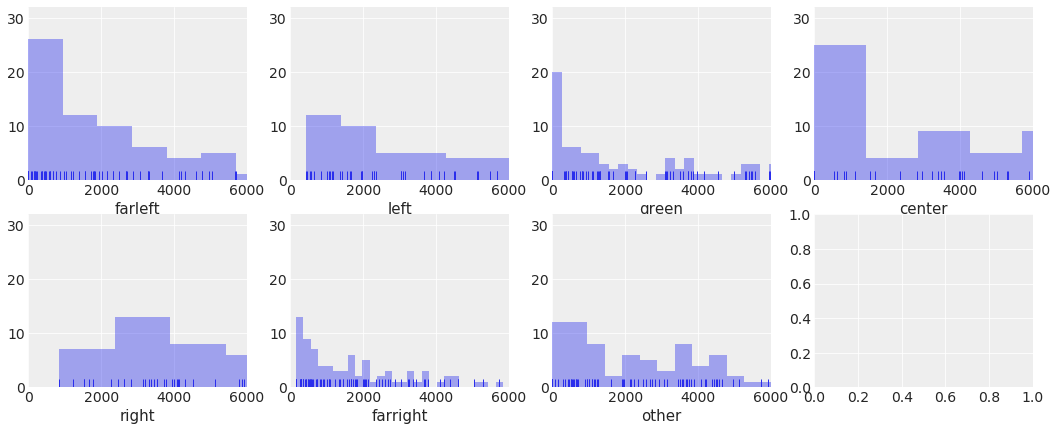

In [30]:
fig, axes = plt.subplots(2, 4, figsize=(18, 7))
i = 0
for line in axes:
    for col in line:
        try:
            sns.distplot(d[PARTIES[i]], bins=30, kde=False, rug=True, ax=col)
            col.set_xlim([0, 6_000])
            col.set_ylim([0, 32])
            i += 1
        except IndexError:
            continue

That's not the best plot, but we can see that farleft, green and center do have a tendency to zero-inflation. Now, how can model this mixed process?

In [1]:
# https://github.com/pymc-devs/pymc3/blob/master/pymc3/distributions/multivariate.py
# https://github.com/pymc-devs/pymc3/blob/master/pymc3/distributions/discrete.py

# https://discourse.pymc.io/t/the-zero-inflated-exponential/2538
# https://discourse.pymc.io/t/literature-on-implementing-a-zero-inflated-beta-likelihood/2503
# https://discourse.pymc.io/t/zero-inflated-poisson-log-lik/2664
# https://discourse.pymc.io/t/sampling-from-a-learned-mixture-of-zeros-and-lognormal/3671/2

# https://www.birs.ca/workshops/2019/19w5128/files/slides_ZIGDM.pdf
# https://rdrr.io/cran/miLineage/man/ZIGDM.html